# How to Predict Recipe Ratings Based on Recipe Complexity
**Name(s)**: Sophia Papadopoulos and Leo Udell

**Website Link**: https://leoudell.github.io/recipe-star-prediction/

In [8]:
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from lec_utils import * # Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

## Step 1: Introduction

Picture this. You come home from a long day at work at the world's best data science company. All you want is a quick bite, but what are the odds this meal will be 5 stars? What is the relation between complexity and star ratings? This analysis explores a dataset of over 730,000 reviews on food.com to determine the relationship between highly rated recipes and recipe complexity. We have defined how complex a recipe can be based on how long it takes to prep and cook, the number of different ingredients, and the number of steps. By analyzing this complexity, we can help chefs optimize the complexity of their recipes for better ratings and different audiences.

**Total Rows in Dataset:** 

| Column Recipe in Dataset   | Description |
|-------------|-------|
| 'name'   | Recipe name|
| 'minutes' | Minutes to prepare recipe |
| 'n_steps' | Number of steps in recipe    |

| Column Rating in Dataset    | Description |
|-------------|-------|
| 'user_id'   | User ID |
| 'rating' | Star rating given by user |

In [10]:
recipes = pd.read_csv('RAW_recipes.csv')
recipes.shape

(83782, 12)

In [11]:
ratings = pd.read_csv('RAW_interactions.csv')
ratings.shape

(731927, 5)

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning
1. The Food.com data came in two separate CSV files, one for the recipes and one for the ratings. We performed an inner join of the recipes and ratings CSVs on the recipe_id field to ensure every rating in our merged set had a corresponding recipe record.
2. We removed columns that were not needed for modeling, like rating text and written steps. After column drops, we checked for NaNs across all remaining fields and found none. However, some ratings had 0 as a rating value; we dropped those rows before training.
3. Our dataframe started around 731,000 rows with 17 columns, and we ended with 220,000 rows with 5 columns after cleaning.

In [12]:
merged_unclean = recipes.merge(ratings, left_on='id', right_on='recipe_id')

In [13]:
merged = merged_unclean[['id', 'contributor_id', 'name', 'minutes', 'n_steps', 'n_ingredients', 'rating']]
merged.sample(5)

,id,contributor_id,name,minutes,n_steps,n_ingredients,rating
229722,454403,1458294,whole wheat raisin bread,155,17,9,5
31381,503260,852554,broiled salmon with spice pomade alton brown,70,14,11,5
268,443640,1751920,he proposed red velvet cake,50,19,13,5
103245,299064,114317,healthy banana pineapple muffins,45,7,13,5
192129,296105,486725,smashed loaded potatoes low fat,15,8,7,4


In [14]:
merged['rating'].value_counts()

rating
5    169676
4     37307
0     15035
3      7172
1      2870
2      2368
Name: count, dtype: int64

In [33]:
merged.sort_values('n_steps', ascending=False).head()

,id,contributor_id,name,minutes,n_steps,n_ingredients,rating
70181,356724,467583,death by chocolate a la trellis,1680,100,19,5
70180,356724,467583,death by chocolate a la trellis,1680,100,19,5
70179,356724,467583,death by chocolate a la trellis,1680,100,19,5
222804,537089,2002205938,vampire s kiss cake,2930,98,18,5
23669,454787,746976,best authentic mexican tamales ever,360,93,13,0


### Univariate Analysis
This plot shows the distribution of ratings between recipes. As shown by the plot, most of the recipes have a 5-star rating. There are also a few recipes with a 0 rating, indicating that the user did not leave a rating for their posted comment. This does not mean that the user rated the recipe poorly, but that they chose not to rate the recipe. Given our goal, keeping these 0-star ratings would give inaccurate final results, so we chose to drop these recipes from our dataset. 

In [ ]:
fig = (
    merged['rating']
    .value_counts()
    .plot(
        kind='bar',
        title='Frequency of Ratings'
    )
)
fig.write_html('uniAnalysis.html', include_plotlyjs='cdn')

In [16]:
merged_non_zero = merged[merged['rating'] != 0]

### Bivariate Analysis
This plot measures the average rating, number of steps, and number of ingredients in each recipe. Typically, as the number of steps increases, so does the preparation time for the recipe. Likewise, when the number of steps increases, so does the number of ingredients. 

In [ ]:
fig = (
    merged_non_zero
    .plot(
        kind='box',
        title='Ratings vs Minutes',
        x='rating',
        y='minutes'
    )
)
#fig.write_html('uniAnalysis.html', include_plotlyjs='cdn')
fig

This plot measures the average rating, number of steps, and minutes to prepare each recipe in the dataset. Both plots are heavily skewed to the left, with most recipes not taking very long; however, there are a few recipes that take over 200,000 minutes. 

In [ ]:
fig = px.scatter(
    merged_non_zero,
    x='minutes',
    y='n_steps',
    hover_name='name',
    color='n_ingredients',
    title='Minutes vs. Number of Steps vs. Ingredients',
)

fig.update_layout(
    xaxis_title='Minutes',
    yaxis_title='Number of Steps',
    legend_title='Number of Ingredients'
)
fig.show()
fig.write_html('bivAnalysisPT2.html', include_plotlyjs='cdn')

### Interesting Aggregates
When constructing the bivariate analysis of the dataset, we were curious about the recipes with the longest preparation time. We came across one recipe with a strange title. Taking over 1 million minutes, "How to Preserve a Husband" has 2 ingredients (cream and peaches) and 2 five-star reviews. 

In [ ]:
pOut = merged_non_zero.sort_values('minutes', ascending=False).head(7).groupby('name').first().drop('contributor_id', axis=1).drop('id', axis=1).sort_values('minutes', ascending=False)
print(pOut)

### Imputation
While cleaning the data, we found that there are no missing values in the dataset. For some recipes, there are 0 ratings for that recipe, and that would then be converted to a NAN value. Due to the model we created, the recipes with zero reviews are not useful and were removed. 

## Step 3: Framing a Prediction Problem

## Problem Identification
What is the average rating for a recipe based on its "complexity"? We have defined recipe "complexity" as the number of ingredients, the number of minutes it takes to complete, and the number of steps included. In order to do this, we constructed a regression model to predict the recipe's start rating of 0 - 5. 
- **Type of Problem:** Our goal was to predict a numerical value: the average recipe rating based on complexity. Since this rating is a continuous variable, we were dealing with a regression problem rather than a classification problem.
- **Evaluation Metric:** We used Mean Squared Error (MSE) as our primary evaluation metric. MSE is well-suited for regression tasks because it directly measures the squared difference between predicted ratings and actual ratings. MSE penalizes large errors and prioritizes accuracy on recipes that would otherwise be error-prone. This was particularly useful in our case due to the several extremely long recipes.

## Step 4: Baseline Model

## Baseline Model
For the baseline model, we chose to use a linear regression model to predict the ratings. We used three features from the recipes data set that were mentioned in our definition of complexity. <br>
*Features*
1. `n_ingredients` (quantitative): The number of ingredients a recipe requires
2. `minutes` (quantitative): The number of minutes it takes to complete a recipe
3. `n_steps` (quantitative): The number of steps it takes to complete a recipe
Since all of the features selected here are quantitative, we did not have to perform any encoding.

**Model Performance**<br>
As stated, we evaluated the performance of our model using Mean Squared Error. The MSE of this model is approximately 0.505. In the context of the rating scale, our model has a prediction error of about `sqrt(0.505) = 0.71`. This means that if a true rating is 3.0, our model will predict that the recipe is anywhere from 2.3 to 3.7 stars. This model is not optimal due to the large variance in possible predictions. Part of this inaccuracy is due in part to the highly skewed training data. With the transformations used in the next steps, we improved the overall model prediction accuracy.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

In [18]:
model_simple = LinearRegression()
model_simple.fit(X=merged_non_zero[['n_ingredients', 'minutes', 'n_steps']], y=merged_non_zero['rating'])
simple_mse = mean_squared_error(merged_non_zero['rating'], model_simple.predict(merged_non_zero[['n_ingredients', 'minutes', 'n_steps']]))
simple_mse

0.5047532308413739

## Step 5: Final Model
In the baseline model, we used the raw values of `n_ingredients`, `minutes`, and `n_steps` to predict the `rating`. This method was not robust to the large outliers that we found in the dataset. In order to account for this, we added features that standardized the data while still keeping the complexity of a recipe intact. 

**New Features**
1. **QuantitativeTransformer**: We utilized this transformer on all of the columns from the baseline model to account for the extreme outliers. This created a uniform distribution of the data, which was crucial for decreasing MSE. MSE is very susceptible to large outliers, and this transformer improved our results.
2. **PolynomialFeatures**: A recipe’s complexity, as we defined it, doesn’t affect ratings strictly linearly. Very basic recipes might appeal to cooks looking for quick meals, while highly intricate ones cater to enthusiasts willing to invest more time. By adding polynomial terms, our model can flexibly fit these subtler patterns instead of forcing a purely linear relationship.

**Modeling Algorithm & Hyperparameters**:
We decided to stick with the Linear Regression model because our newly added features account for outliers and adjusting the degree of predictions. For the hyperparameters, we tuned the PolynomialFeature degree. We utlized GridSearchCV to try all degrees between 1 and 9 inclusive. With that method, we found that the best degree was a degree 4 polynomial. 

**Performance Enhancements**:
As stated previously, our baseline model achieved an MSE of 0.505. Our new model achieved a modest improvement, reducing the MSE to 0.503. This final model adjusts for outliers, which was the main factor in decreasing the MSE, and produces predictions that are more accurate relative to the true center of the data. Moving forward, this outlier‑robust approach can be extended with additional regularization or alternative loss functions to further enhance model stability and predictive performance.

**Model Performance Plots**:
To model our model's performance, we needed to keep one of the variables constant. Pictured below are 3D plots to help visualize performance when one variable is kept at the constant median of that variable. Some interesting points provided by these plots are that when steps are held constant, the model performs poorly when minutes are low, and there are 10 ingredients. It could be true that recipes advertising short preparation times but demanding many ingredients may frustrate users, or low-minute, 10-ingredient recipes are rare. Another interesting point is that the model performs best when minutes are kept consistent and ingredients and steps are varied. This is most likely due to the large time-based outliers present in the data. Under these conditions, it performs worse when there are few steps and few ingredients, suggesting that users do not look for or make incredibly simple recipes, such as a baked potato or cereal.


In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import QuantileTransformer

def create_pipe_cross_validated_degree(X_train, y_train):
    preprocessing = make_column_transformer(
        (QuantileTransformer(), ['n_ingredients', 'minutes', 'n_steps']),
        remainder='drop'
    )
    
    hyperparams = {
        'polynomialfeatures__degree': range(1, 10)
    }
    
    model_regularized = GridSearchCV(
        estimator=make_pipeline(preprocessing, PolynomialFeatures(include_bias=False), LinearRegression()),
        param_grid=hyperparams,
        scoring='neg_mean_squared_error'
    )
    return model_regularized.fit(X_train, y_train)

model_cross = create_pipe_cross_validated_degree(merged_non_zero[['n_ingredients', 'minutes', 'n_steps']], merged_non_zero['rating'])
cross_mse = mean_squared_error(merged_non_zero['rating'], model_cross.predict(merged_non_zero[['n_ingredients', 'minutes', 'n_steps']]))

cross_mse

0.5034706516465115

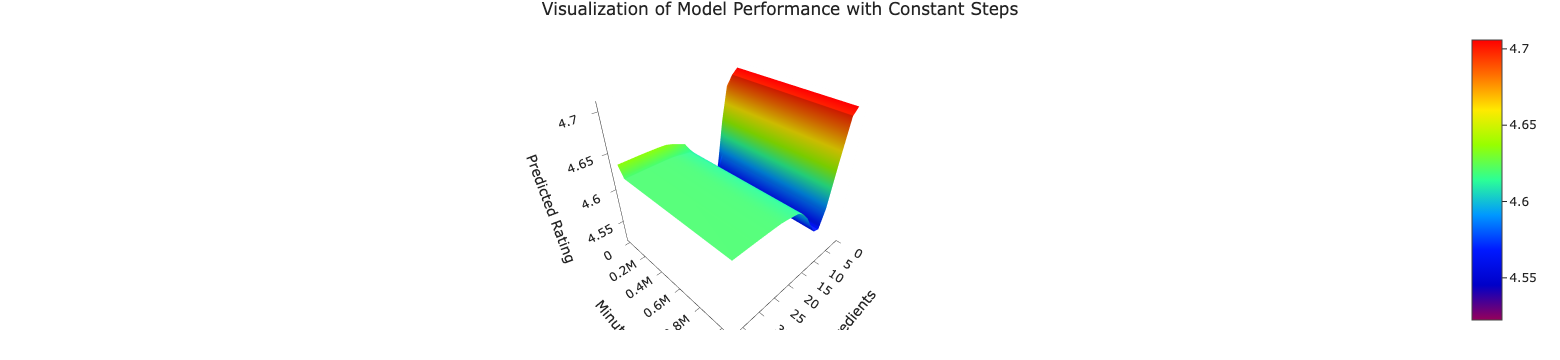

In [27]:
x_grid, y_grid = np.mgrid[
    merged_non_zero['n_ingredients'].min():merged_non_zero['n_ingredients'].max():20j,
    merged_non_zero['minutes'].min():merged_non_zero['minutes'].max():20j
]

grid_df = pd.DataFrame({
    'n_ingredients': x_grid.ravel(),
    'minutes': y_grid.ravel(),
    'n_steps': merged_non_zero['n_steps'].median()  # Hold constant
})

z = model_cross.predict(grid_df).reshape(x_grid.shape)

fig = go.Figure(data=[
    go.Surface(
        x=x_grid,
        y=y_grid,
        z=z,
        colorscale='Rainbow'
    )
])
fig.update_layout(
    scene=dict(
        xaxis_title='Ingredients',
        yaxis_title='Minutes',
        zaxis_title='Predicted Rating'
    ),
    title='Visualization of Model Performance with Constant Steps'
)
fig.show()
fig.write_html('finMConstSTEPS.html', include_plotlyjs='cdn')

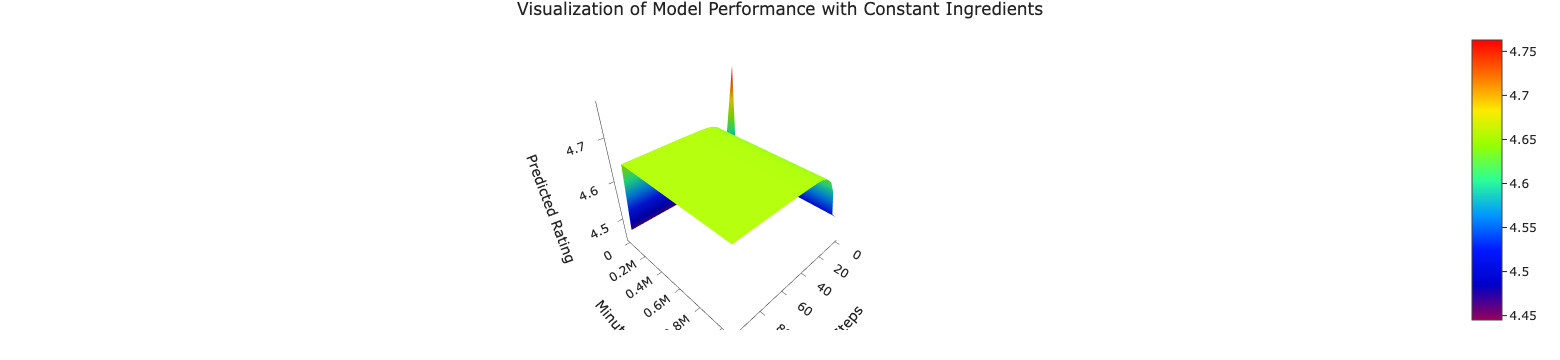

In [35]:
x_grid, y_grid = np.mgrid[
    merged_non_zero['n_steps'].min():merged_non_zero['n_steps'].max():20j,
    merged_non_zero['minutes'].min():merged_non_zero['minutes'].max():20j
]

grid_df = pd.DataFrame({
    'n_ingredients': merged_non_zero['n_ingredients'].median(),  # Hold constant
    'minutes': y_grid.ravel(),
    'n_steps': x_grid.ravel()
})

z = model_cross.predict(grid_df).reshape(x_grid.shape)

fig = go.Figure(data=[
    go.Surface(
        x=x_grid,
        y=y_grid,
        z=z,
        colorscale='Rainbow'
    )
])
fig.update_layout(
    scene=dict(
        xaxis_title='Steps',
        yaxis_title='Minutes',
        zaxis_title='Predicted Rating'
    ),
    title='Visualization of Model Performance with Constant Ingredients'
)
fig.show()
fig.write_html('finMConstING.html', include_plotlyjs='cdn')

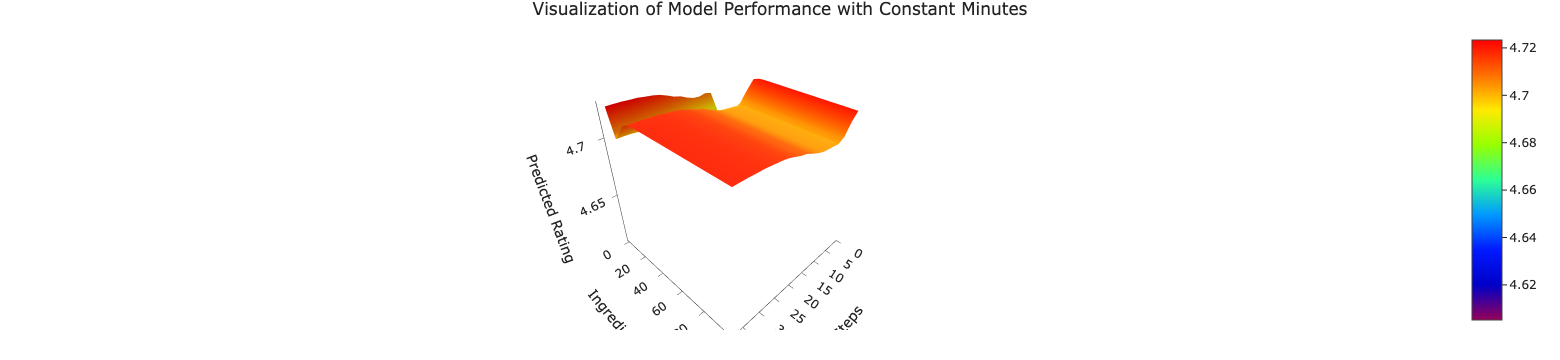

In [36]:
x_grid, y_grid = np.mgrid[
    merged_non_zero['n_ingredients'].min():merged_non_zero['n_ingredients'].max():20j,
    merged_non_zero['n_steps'].min():merged_non_zero['n_steps'].max():20j
]

grid_df = pd.DataFrame({
    'n_ingredients': y_grid.ravel(),  # Hold constant
    'minutes': merged_non_zero['minutes'].median(), # Hold constant
    'n_steps': x_grid.ravel()
})

z = model_cross.predict(grid_df).reshape(x_grid.shape)

fig = go.Figure(data=[
    go.Surface(
        x=x_grid,
        y=y_grid,
        z=z,
        colorscale='Rainbow'
    )
])
fig.update_layout(
    scene=dict(
        xaxis_title='Steps',
        yaxis_title='Ingredients',
        zaxis_title='Predicted Rating'
    ),
    title='Visualization of Model Performance with Constant Minutes'
)
fig.show()
fig.write_html('finMConstMIN.html', include_plotlyjs='cdn')